##  Imports

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import eurostat
import os

%matplotlib inline

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats

In [49]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.datasets import make_hastie_10_2

In [50]:
sns.set_theme('notebook')
warnings.filterwarnings("ignore")

In [51]:
PATH = "clean_data/sweden_eurostat.csv"
RANDOM_STATE = 11

## Utils

In [52]:
def plot_dataframe(df, n_cols=4, plot='hist'):
    num_cols = df.select_dtypes(include='number').columns
    n_rows = int(len(num_cols) / n_cols) + 1

    plots = ['hist', 'box']
    
    if plot not in plots:
        return print("Unknown plot option.")
    
    plt.figure(figsize=(20, 15))
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        
        if plot == 'hist':
            sns.histplot(data=df, x=col, kde=True)
        elif plot == 'box':
            sns.boxplot(data=df, x=col)
        
        plt.title(col, fontsize=10)
        plt.tight_layout()

    plt.show()
    
    return None

In [53]:
def impute_missing_data(raw_df):
    df = raw_df.copy()
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
    df = df.set_index('TIME_PERIOD')
    
    numeric_cols = df.select_dtypes(include='number').columns
    
    for col in numeric_cols:
        df[col] = df[col].interpolate(method='time', limit_direction='both').round(1)
    
    return df

In [54]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [55]:
def model_creation(numerical_cols, categorical_cols, model, folds=6, scaler='standard'):
    if scaler == 'standard':
        scaler_transformer = StandardScaler()
    elif scaler == 'minmax':
        scaler_transformer = MinMaxScaler()
    elif scaler == 'robust':
        scaler_transformer = RobustScaler()
    else:
        scaler_transformer = 'passthrough'
    
    numerical_transformer = Pipeline(steps=[
        # ('imputer', SimpleImputer(strategy='median')),
        ('scaler', scaler_transformer)
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    reg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    cv = KFold(n_splits=(folds - 1), shuffle=True, random_state=RANDOM_STATE)
    
    return reg, cv

In [56]:
def cross_validation(clf, X_train, y_train, cv, method):
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=method)

    for i in range(len(scores)):
        print(f"Fold {i}. {method} Score: {scores[i]*100:.5f}%")

    print(f"Average {method} score: {np.mean(scores)*100:.5f}%")

    return None

In [57]:
def model_acc(y_test, y_pred, model_name="Regression Model"):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    print(f"Model - {model_name}")
    print(f"R² Score: {r2:.5f}")
    print(f"MAE: {mae:.5f}")
    print(f"MSE: {mse:.5f}")
    print(f"RMSE: {rmse:.5f}")
    if mape < 50:
        print(f"MAPE: {mape:.2f}%")
    else:
        print(f"MAPE score is unreliable.")
    
    return None

In [58]:
def train_and_evaluate(
        X_train, X_test, y_train, y_test,
        numerical_cols, categorical_cols, model_dict, folds=6,
        selection_metric='Test R²'
): 
    results = []
    predictions = {}
    models_trained = {}
    best_model = None
    best_name = None
    best_score = -float('inf')
    
    for name, model in model_dict.items():
        print(f"\n--- Training {name} ---")
        reg, cv = model_creation(numerical_cols, categorical_cols, model, folds=folds)
        
        cross_validation(reg, X_train, y_train, cv, method='r2')
        
        reg.fit(X_train, y_train)

        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)

        # Collect metrics
        metrics = {
            "Model": name,
            "Train R²": r2_score(y_train, y_pred_train),
            "Test R²": r2_score(y_test, y_pred_test),
            "Train MAE": mean_absolute_error(y_train, y_pred_train),
            "Test MAE": mean_absolute_error(y_test, y_pred_test),
            "Train RMSE": mean_squared_error(y_train, y_pred_train),
            "Test RMSE": mean_squared_error(y_test, y_pred_test),
        }
        results.append(metrics)

        # Store predictions
        predictions[name] = {
            'y_train_pred': y_pred_train,
            'y_test_pred': y_pred_test
        }

        # Store trained model
        models_trained[name] = reg

        # Update best model
        if metrics[selection_metric] > best_score:
            best_score = metrics[selection_metric]
            best_model = reg
            best_name = name

    results_df = pd.DataFrame(results)
    return results_df, best_name, best_model, predictions, models_trained

In [59]:
def parameter_tuning(
        name, regressor, param_grid,
        numerical_cols, categorical_cols ,
        X_train, y_train,
        cv=5, n_jobs=-1
):
    
    reg, cv = model_creation(numerical_cols, categorical_cols, regressor)
    param_grid = {f"model__{key}": value for key, value in param_grid.items()}
    grid_search = GridSearchCV(reg, param_grid, scoring='r2', refit='r2', cv=cv, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    results = pd.DataFrame(grid_search.cv_results_)
    print(f"Model - {name}")
    print(grid_search.best_params_)
 
    return None

In [60]:
models_tuning = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(random_state=RANDOM_STATE),
    "LassoRegression": Lasso(random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(random_state=RANDOM_STATE)
}

param_grids = {
    "LinearRegression": {
        "fit_intercept": [True, False],
        "positive": [False, True]
    },
    "RidgeRegression": {
        "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
        "solver": ["auto", "svd", "cholesky", "sparse_cg", "lsqr"],
        "fit_intercept": [True, False]
    },
    "LassoRegression": {
        "alpha": [0.001, 0.01, 0.1, 1.0],
        "max_iter": [5000, 10000, 20000],
        "fit_intercept": [True, False],
        "selection": ["cyclic", "random"]
    },
    "RandomForestRegressor": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
    }
}

### Load Dataset

In [61]:
df = pd.read_csv(PATH)

df.head()

,TIME_PERIOD,gdp_quarterly,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate_quarterly,household_income
0,2000-01-01,73909.7,27.975,34240.0,78.83,NaN,-0.5,1.0,49.47555,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,NaN,NaN
1,2000-02-01,NaN,NaN,NaN,79.20,NaN,0.5,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.5,10.7,NaN,NaN
2,2000-03-01,NaN,NaN,NaN,79.59,NaN,0.5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.3,10.5,NaN,NaN
3,2000-04-01,76073.7,NaN,NaN,79.49,NaN,-0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.1,11.6,2.9,NaN
4,2000-05-01,NaN,NaN,NaN,79.96,NaN,0.6,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,5.1,9.6,NaN,NaN


In [62]:
df.isnull().sum()

TIME_PERIOD                    0
gdp_quarterly                206
education_attainment         284
gdp_per_capita               284
price_index                    0
energy_prices                272
inflation_rate_monthly_m       0
inflation_rate_monthly_y       0
gas_emissions                285
net_migration                284
total_population             284
net_population_growth        284
growth_rate                  284
births                       284
deaths                       284
total_unemployment_rate        0
adult_unemployment_rate        0
youth_unemployment_rate        0
gdp_growth_rate_quarterly    207
household_income             288
dtype: int64

## Model Creation

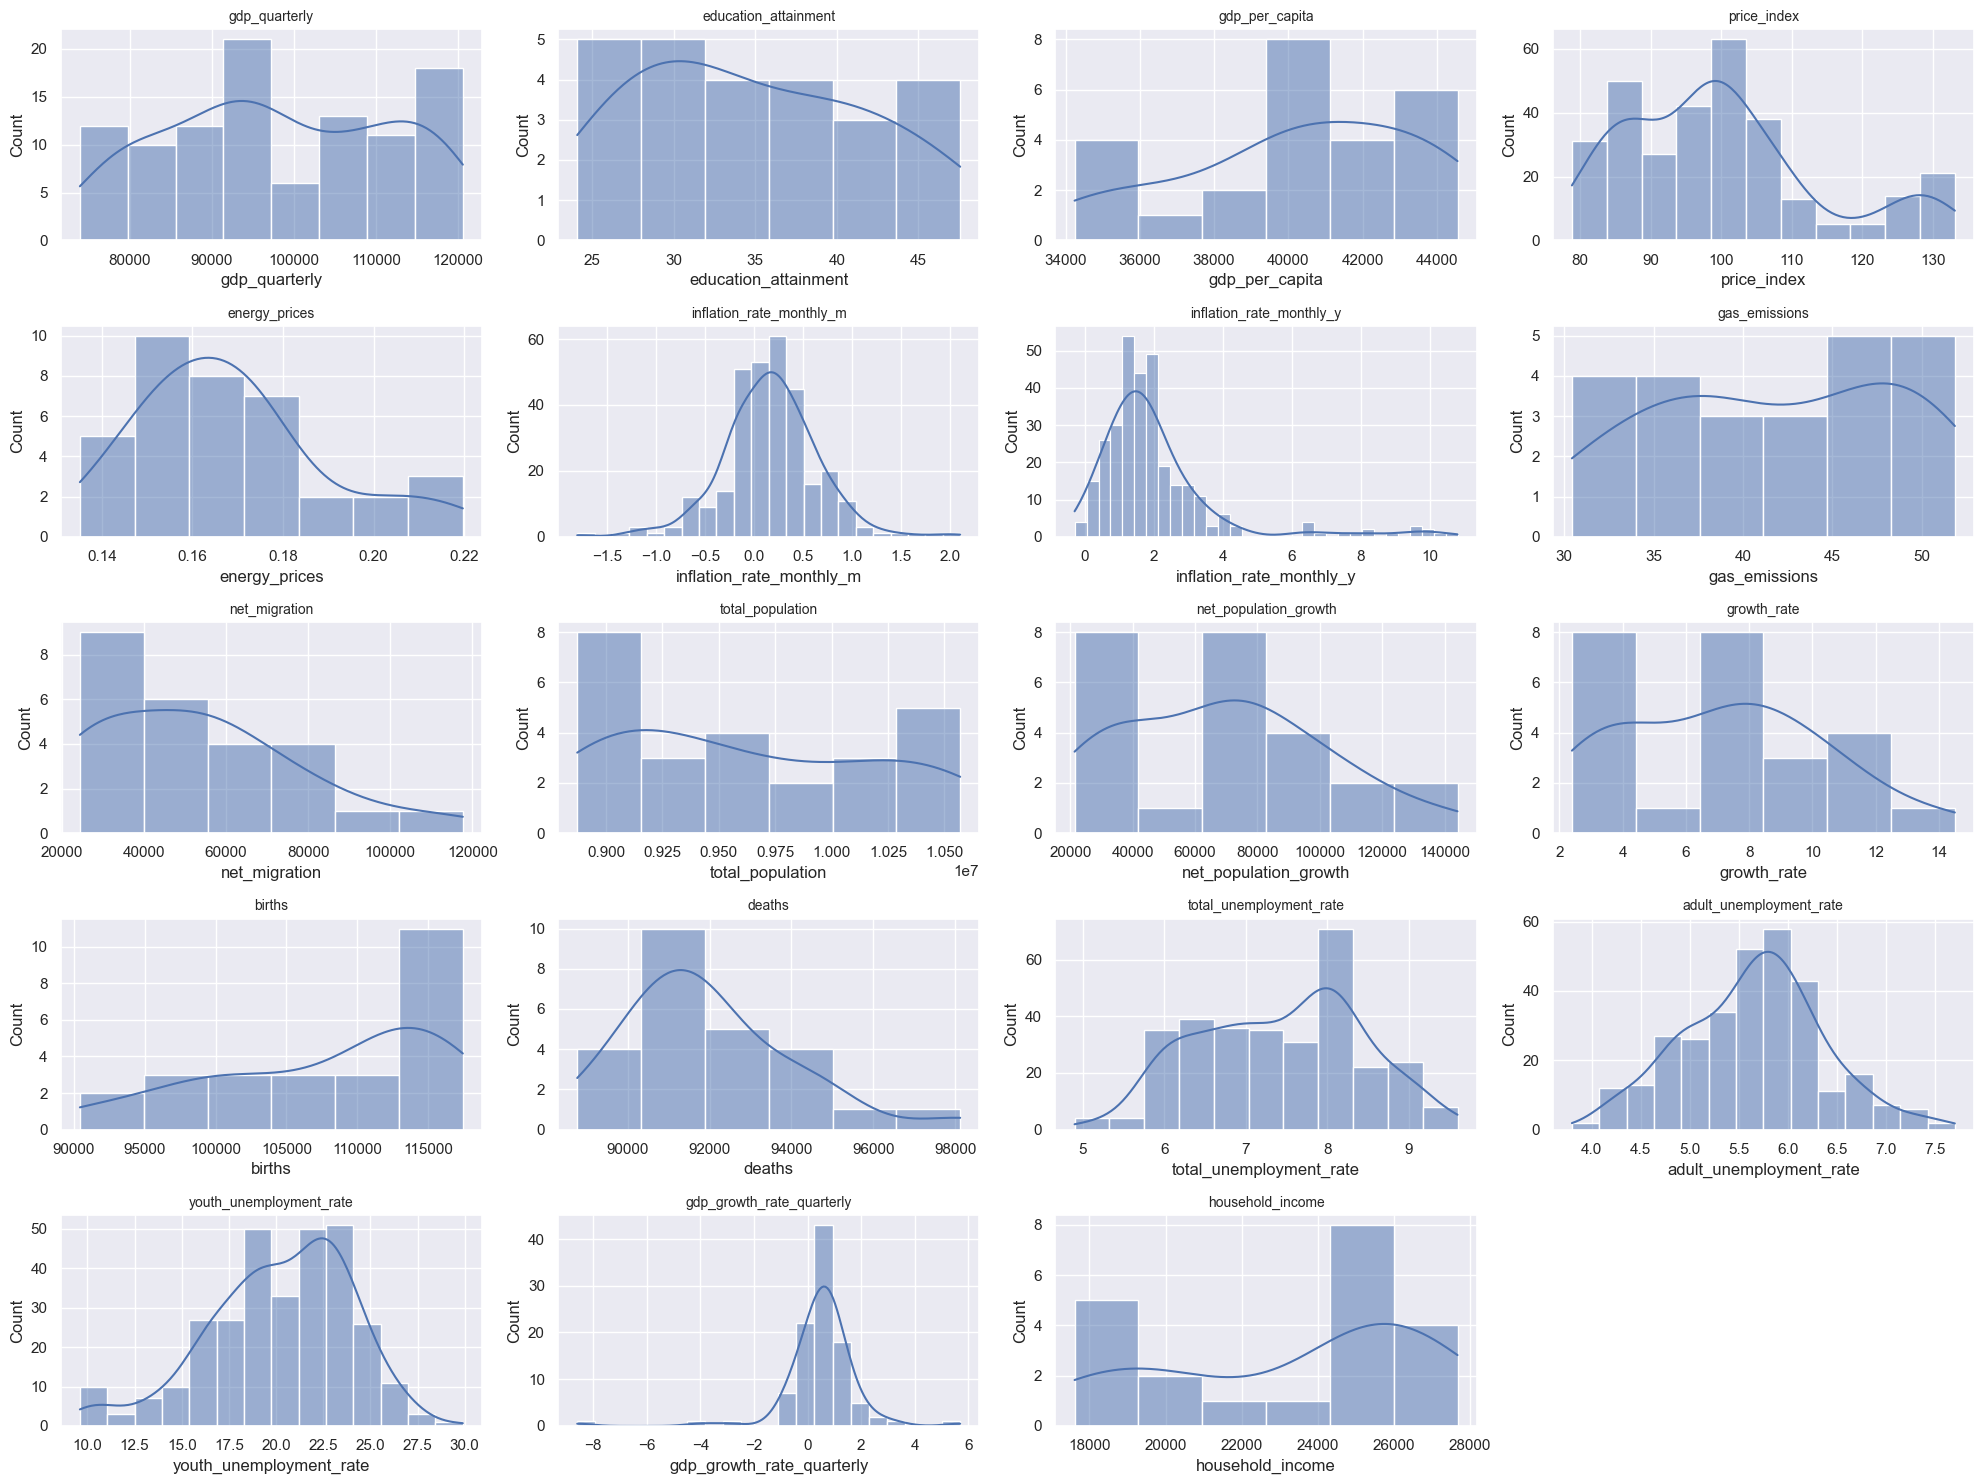

In [63]:
plot_dataframe(df=df, plot='hist')

In [64]:
df = impute_missing_data(df)

df.head()

,gdp_quarterly,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate_quarterly,household_income
TIME_PERIOD,,,,,,,,,,,,,,,,,,,
2000-01-01,73909.7,28.0,34240.0,78.8,0.1,-0.5,1.0,49.5,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,2.9,17608.7
2000-02-01,74646.9,27.6,34270.5,79.2,0.1,0.5,1.4,49.5,24744.8,8874129.2,21787.0,2.5,90527.8,93485.6,6.1,5.5,10.7,2.9,17608.7
2000-03-01,75336.5,27.3,34299.0,79.6,0.1,0.5,1.3,49.6,25080.4,8876019.0,22180.8,2.5,90609.0,93508.7,5.9,5.3,10.5,2.9,17608.7
2000-04-01,76073.7,27.0,34329.5,79.5,0.1,-0.1,1.0,49.7,25439.2,8878039.2,22601.7,2.5,90695.8,93533.4,5.9,5.1,11.6,2.9,17608.7
2000-05-01,76321.7,26.7,34359.0,80.0,0.1,0.6,1.3,49.7,25786.4,8879994.2,23009.1,2.6,90779.9,93557.2,5.6,5.1,9.6,2.3,17608.7


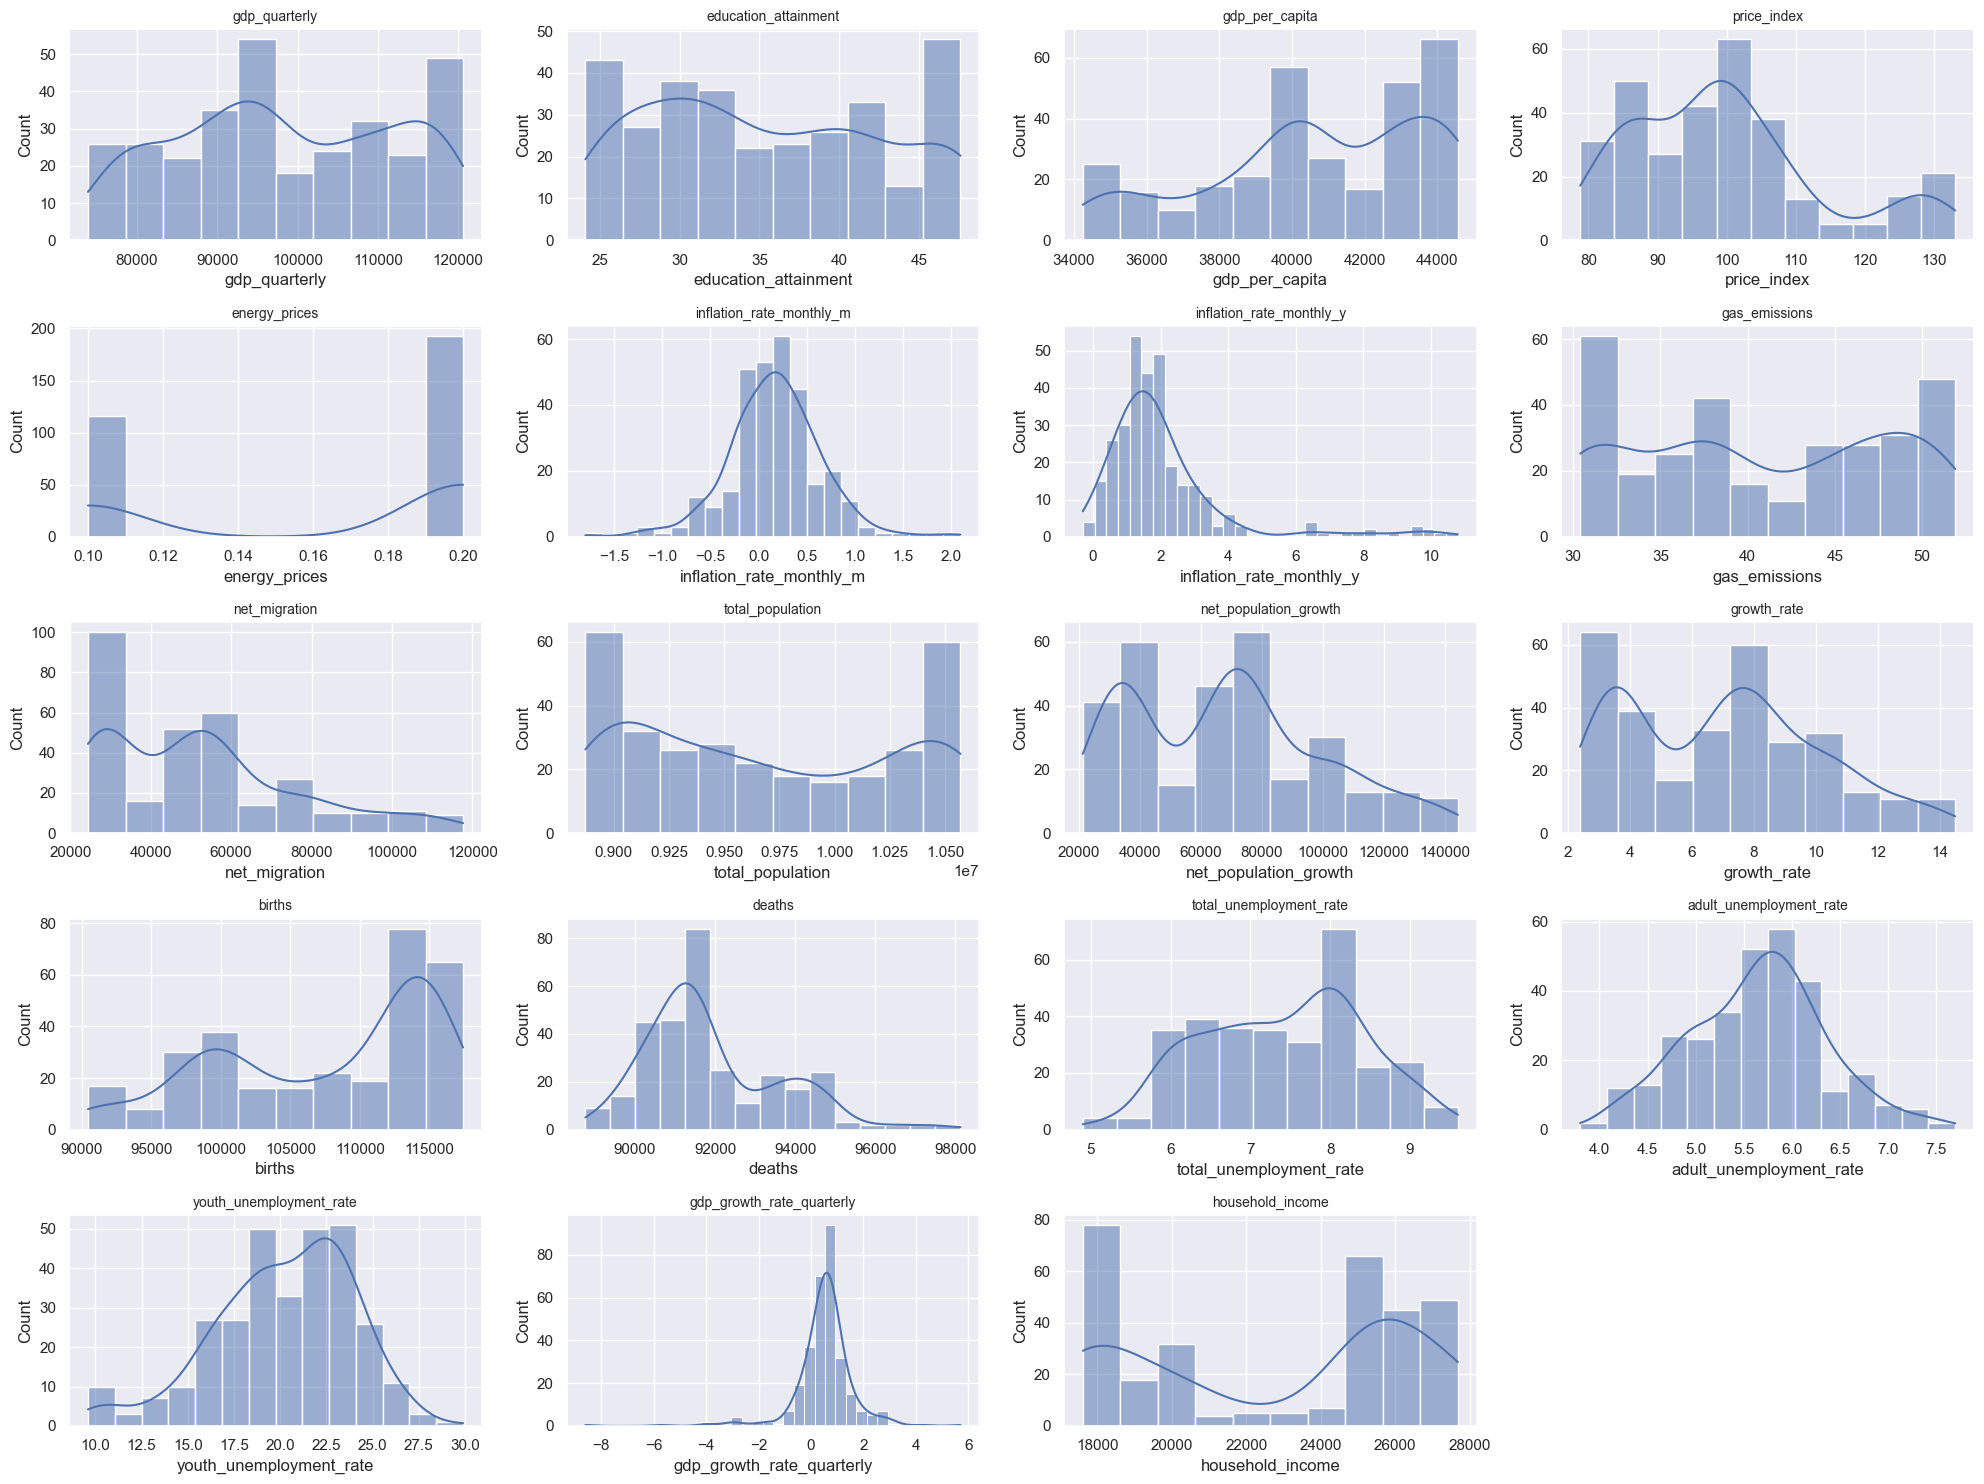

In [65]:
# Visualize data distribution after imputation
plot_dataframe(df=df, plot='hist')

In [66]:
df.isnull().sum()

gdp_quarterly                0
education_attainment         0
gdp_per_capita               0
price_index                  0
energy_prices                0
inflation_rate_monthly_m     0
inflation_rate_monthly_y     0
gas_emissions                0
net_migration                0
total_population             0
net_population_growth        0
growth_rate                  0
births                       0
deaths                       0
total_unemployment_rate      0
adult_unemployment_rate      0
youth_unemployment_rate      0
gdp_growth_rate_quarterly    0
household_income             0
dtype: int64

In [67]:
df.head()

,gdp_quarterly,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate_quarterly,household_income
TIME_PERIOD,,,,,,,,,,,,,,,,,,,
2000-01-01,73909.7,28.0,34240.0,78.8,0.1,-0.5,1.0,49.5,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,2.9,17608.7
2000-02-01,74646.9,27.6,34270.5,79.2,0.1,0.5,1.4,49.5,24744.8,8874129.2,21787.0,2.5,90527.8,93485.6,6.1,5.5,10.7,2.9,17608.7
2000-03-01,75336.5,27.3,34299.0,79.6,0.1,0.5,1.3,49.6,25080.4,8876019.0,22180.8,2.5,90609.0,93508.7,5.9,5.3,10.5,2.9,17608.7
2000-04-01,76073.7,27.0,34329.5,79.5,0.1,-0.1,1.0,49.7,25439.2,8878039.2,22601.7,2.5,90695.8,93533.4,5.9,5.1,11.6,2.9,17608.7
2000-05-01,76321.7,26.7,34359.0,80.0,0.1,0.6,1.3,49.7,25786.4,8879994.2,23009.1,2.6,90779.9,93557.2,5.6,5.1,9.6,2.3,17608.7


In [68]:
numeric_cols = df.select_dtypes(include='number').columns
outliers_dict = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    if not outliers.empty:
        outliers_dict[col] = outliers

outliers_df = pd.DataFrame.from_dict(outliers_dict).reset_index(names='index_row')

outliers_df = outliers_df.drop(columns=['inflation_rate_monthly_y', 'inflation_rate_monthly_m', 'index_row'])
outliers_df = outliers_df.dropna(how='all')
outliers_df

,net_migration,deaths,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate_quarterly
0,NaN,NaN,NaN,NaN,2.9
1,NaN,NaN,NaN,NaN,2.9
2,NaN,NaN,NaN,NaN,2.9
3,NaN,NaN,NaN,NaN,2.9
4,NaN,NaN,NaN,9.6,2.3
5,NaN,NaN,NaN,9.6,NaN
6,NaN,NaN,NaN,9.9,NaN
7,NaN,NaN,NaN,9.8,NaN
8,NaN,NaN,NaN,NaN,-1.9
9,NaN,NaN,NaN,NaN,-3.0


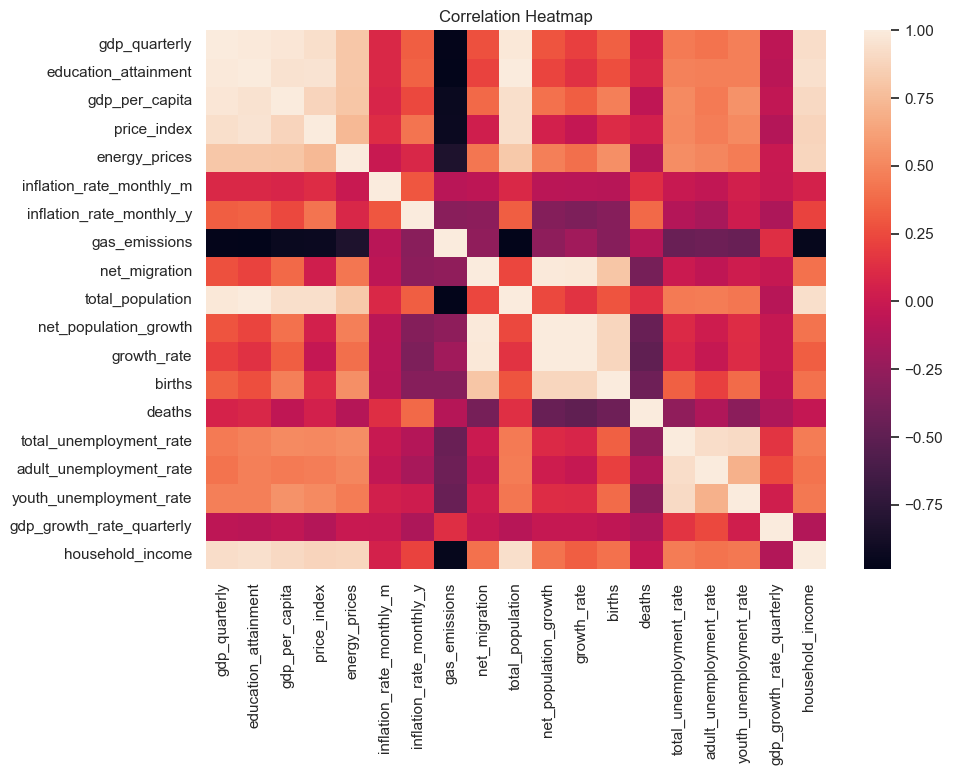

In [69]:
num_df = df.select_dtypes(include='number')
corr_data = num_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(data=corr_data, annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [70]:
clean_df = pd.DataFrame()
subset = df[[
    'gdp_growth_rate_quarterly', 'births', 'deaths', 
    'inflation_rate_monthly_y', 'total_unemployment_rate',
    'household_income', 'net_migration'
]]

clean_df = subset.dropna()
clean_df = add_constant(clean_df)

vif_df = pd.DataFrame()
vif_df['features'] = clean_df.columns # pyright: ignore[reportAttributeAccessIssue]
vif_df['VIF'] = [variance_inflation_factor(clean_df.values, i) for i in range(clean_df.shape[1])] # pyright: ignore[reportAttributeAccessIssue]

vif_df.sort_values(by="VIF", ascending=False)

,features,VIF
0,const,5284.716627
7,net_migration,5.144466
2,births,4.470418
5,total_unemployment_rate,2.519984
6,household_income,2.371457
4,inflation_rate_monthly_y,1.505850
3,deaths,1.492122
1,gdp_growth_rate_quarterly,1.136738


In [71]:
subset = df[[
    'gdp_growth_rate_quarterly', 'births', 'deaths', 
    'inflation_rate_monthly_y', 'total_unemployment_rate',
    'household_income', 'net_migration'
]]

### Model 1 (GDP Growth)

In [72]:
features = subset.copy()
# features = df.copy()
target = features.pop('gdp_growth_rate_quarterly')

features.columns

Index(['births', 'deaths', 'inflation_rate_monthly_y',
       'total_unemployment_rate', 'household_income', 'net_migration'],
      dtype='object')

In [73]:
for colname in features.select_dtypes("object"):
    features[colname], _ = features[colname].factorize()

discrete_features = features.dtypes == int

In [74]:
mi_scores = make_mi_scores(features, target, discrete_features)
mi_scores[::]

births                      0.425890
net_migration               0.340808
household_income            0.277835
deaths                      0.203490
total_unemployment_rate     0.075132
inflation_rate_monthly_y    0.011495
Name: MI Scores, dtype: float64

In [75]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

numerical_cols = list(features.select_dtypes('number').columns)
categorical_cols = list(features.select_dtypes('object').columns)
print("Object Columns:", categorical_cols,
      "Numerical Columns: ", numerical_cols)

Object Columns: [] Numerical Columns:  ['births', 'deaths', 'inflation_rate_monthly_y', 'total_unemployment_rate', 'household_income', 'net_migration']


In [76]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(key, models_tuning[key], value, numerical_cols, categorical_cols, X_train, y_train)

Model - LinearRegression
{'model__fit_intercept': True, 'model__positive': True}

---

Model - RidgeRegression
{'model__alpha': 100.0, 'model__fit_intercept': True, 'model__solver': 'svd'}

---

Model - LassoRegression
{'model__alpha': 1.0, 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__selection': 'cyclic'}

---

Model - RandomForestRegressor
{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}

In [77]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=True),
    "RidgeRegression": Ridge(alpha=100.0, fit_intercept=True, solver='svd', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=1.0, fit_intercept=True, max_iter=5000, selection='cyclic', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    )
}

In [78]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---
Fold 0. r2 Score: -2.69292%
Fold 1. r2 Score: 5.98071%
Fold 2. r2 Score: -17.49265%
Fold 3. r2 Score: 5.46433%
Fold 4. r2 Score: 3.60247%
Average r2 score: -1.02761%

--- Training RidgeRegression ---
Fold 0. r2 Score: -0.47401%
Fold 1. r2 Score: -0.10346%
Fold 2. r2 Score: -15.62205%
Fold 3. r2 Score: 9.66464%
Fold 4. r2 Score: 1.03863%
Average r2 score: -1.09925%

--- Training LassoRegression ---
Fold 0. r2 Score: -3.15489%
Fold 1. r2 Score: -0.03032%
Fold 2. r2 Score: -2.98054%
Fold 3. r2 Score: -2.71916%
Fold 4. r2 Score: -0.05157%
Average r2 score: -1.78730%

--- Training RandomForestRegressor ---
Fold 0. r2 Score: 35.03543%
Fold 1. r2 Score: 39.07850%
Fold 2. r2 Score: 3.90983%
Fold 3. r2 Score: 50.82880%
Fold 4. r2 Score: 65.18636%
Average r2 score: 38.80778%


In [79]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.025045,0.002693,0.706028,0.505037,1.559096,0.475065
1,RidgeRegression,0.089389,0.010718,0.672364,0.526350,1.456201,0.471242
2,LassoRegression,0.000000,-0.010009,0.700592,0.520125,1.599146,0.481115
3,RandomForestRegressor,0.919483,0.573898,0.228921,0.338767,0.128758,0.202973


In [80]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                                    OLS Regression Results                                    
Dep. Variable:     gdp_growth_rate_quarterly   R-squared (uncentered):                   0.115
Model:                                   OLS   Adj. R-squared (uncentered):              0.093
Method:                        Least Squares   F-statistic:                              5.235
Date:                       Sun, 02 Nov 2025   Prob (F-statistic):                    4.35e-05
Time:                               20:59:40   Log-Likelihood:                         -412.89
No. Observations:                        247   AIC:                                      837.8
Df Residuals:                            241   BIC:                                      858.8
Df Model:                                  6                                                  
Covariance Type:                   nonrobust                                                  
                 coef    std err          t      P

In [81]:
rf = best_model.named_steps['model']
all_feature = list(numerical_cols)
importance_df = pd.DataFrame({
    'Feature': all_feature,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

                    Feature  Importance
1                    deaths    0.234178
2  inflation_rate_monthly_y    0.188308
0                    births    0.155311
5             net_migration    0.143627
4          household_income    0.139921
3   total_unemployment_rate    0.138655


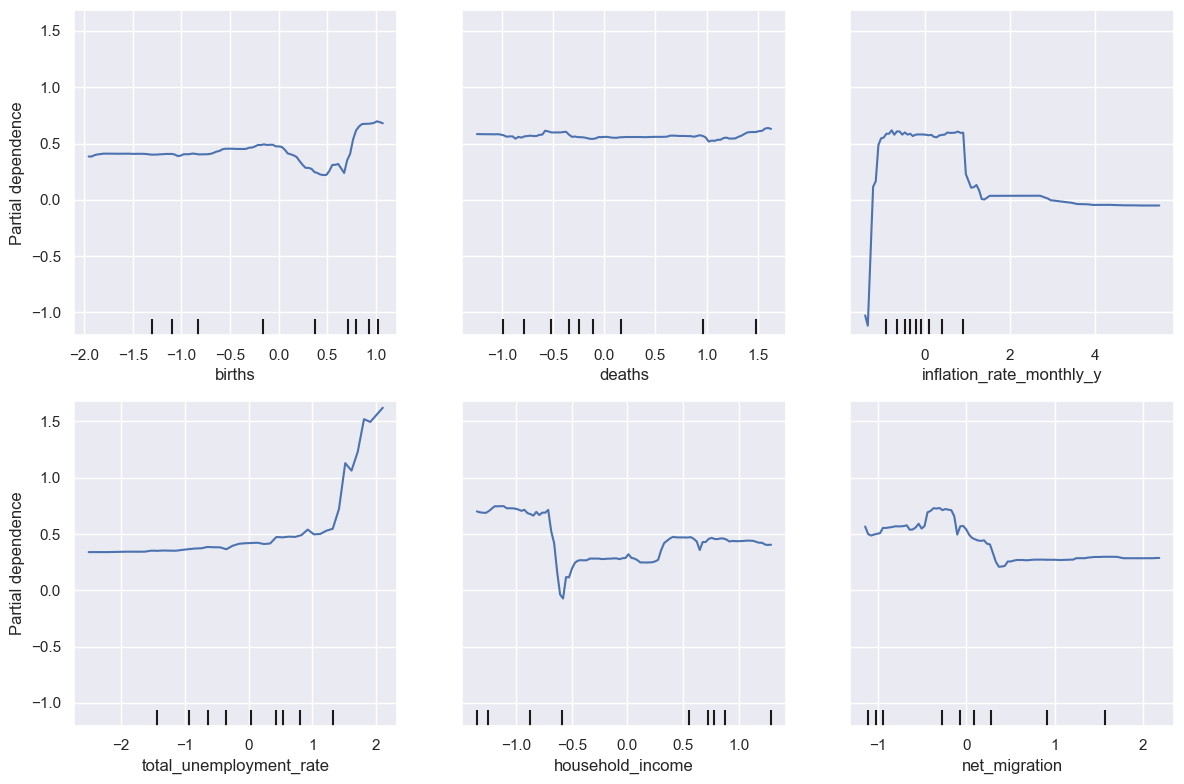

In [82]:
X_transformed = best_model.named_steps['preprocessor'].transform(features)

plot = PartialDependenceDisplay.from_estimator(
    best_model.named_steps['model'],  
    X_transformed,                     
    features=features,
    feature_names=features.columns
)

fig = plot.figure_
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [83]:
y_pred = predictions['LinearRegression']['y_test_pred']
residuals = y_test - y_pred

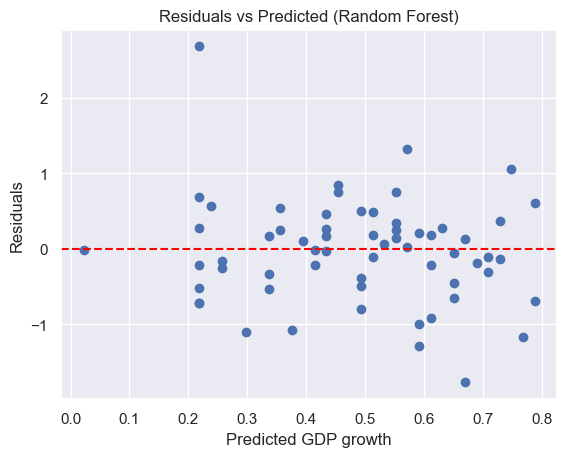

In [84]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP growth")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Random Forest)")
plt.show()

### Model 2 (Inflation Rate)

In [85]:
features = subset.copy()
target = features.pop('inflation_rate_monthly_y')

features.columns

Index(['gdp_growth_rate_quarterly', 'births', 'deaths',
       'total_unemployment_rate', 'household_income', 'net_migration'],
      dtype='object')

In [86]:
for colname in features.select_dtypes("object"):
    features[colname], _ = features[colname].factorize()

discrete_features = features.dtypes == int

In [87]:
mi_scores = make_mi_scores(features, target, discrete_features)
mi_scores[::]

births                       0.663525
household_income             0.537866
net_migration                0.469398
deaths                       0.407697
total_unemployment_rate      0.308244
gdp_growth_rate_quarterly    0.000000
Name: MI Scores, dtype: float64

In [88]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

numerical_cols = list(features.select_dtypes('number').columns)
categorical_cols = list(features.select_dtypes('object').columns)
print("Object Columns:", categorical_cols,
      "Numerical Columns: ", numerical_cols)

Object Columns: [] Numerical Columns:  ['gdp_growth_rate_quarterly', 'births', 'deaths', 'total_unemployment_rate', 'household_income', 'net_migration']


In [89]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(key, models_tuning[key], value, numerical_cols, categorical_cols, X_train, y_train)

Model - LinearRegression
{'model__fit_intercept': True, 'model__positive': True}

---

Model - RidgeRegression
{'model__alpha': 100.0, 'model__fit_intercept': True, 'model__solver': 'svd'}

---

Model - LassoRegression
{'model__alpha': 0.1, 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__selection': 'cyclic'}

---

Model - RandomForestRegressor
{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}

In [90]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=True),
    "RidgeRegression": Ridge(alpha=100.0, fit_intercept=True, solver='svd', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.1, fit_intercept=True, max_iter=5000, selection='cyclic', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=50,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    )
}

In [91]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---
Fold 0. r2 Score: 5.08516%
Fold 1. r2 Score: 17.36986%
Fold 2. r2 Score: -31.67868%
Fold 3. r2 Score: 17.60462%
Fold 4. r2 Score: 18.89420%
Average r2 score: 5.45503%

--- Training RidgeRegression ---
Fold 0. r2 Score: 17.41507%
Fold 1. r2 Score: 26.38752%
Fold 2. r2 Score: -62.97854%
Fold 3. r2 Score: 24.49729%
Fold 4. r2 Score: 20.36188%
Average r2 score: 5.13664%

--- Training LassoRegression ---
Fold 0. r2 Score: 12.48723%
Fold 1. r2 Score: 27.36131%
Fold 2. r2 Score: -87.37514%
Fold 3. r2 Score: 25.57356%
Fold 4. r2 Score: 16.46299%
Average r2 score: -1.09801%

--- Training RandomForestRegressor ---
Fold 0. r2 Score: 93.50735%
Fold 1. r2 Score: 95.54332%
Fold 2. r2 Score: 76.31483%
Fold 3. r2 Score: 89.99901%
Fold 4. r2 Score: 90.88015%
Average r2 score: 89.24893%


In [92]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.152436,0.214954,1.023865,1.290541,2.188749,4.762123
1,RidgeRegression,0.253761,0.259425,0.947025,1.222568,1.927089,4.492363
2,LassoRegression,0.256966,0.267805,0.953973,1.234114,1.918810,4.441531
3,RandomForestRegressor,0.985935,0.818899,0.139566,0.569887,0.036323,1.098566


In [93]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     inflation_rate_monthly_y   R-squared (uncentered):                   0.116
Model:                                  OLS   Adj. R-squared (uncentered):              0.095
Method:                       Least Squares   F-statistic:                              5.296
Date:                      Sun, 02 Nov 2025   Prob (F-statistic):                    3.77e-05
Time:                              20:59:42   Log-Likelihood:                         -563.82
No. Observations:                       247   AIC:                                      1140.
Df Residuals:                           241   BIC:                                      1161.
Df Model:                                 6                                                  
Covariance Type:                  nonrobust                                                  
                 coef    std err          t      P>|t|      

### Model 3 (Unemployment Rate)

In [94]:
features = subset.copy()
target = features.pop('total_unemployment_rate')

features.columns

Index(['gdp_growth_rate_quarterly', 'births', 'deaths',
       'inflation_rate_monthly_y', 'household_income', 'net_migration'],
      dtype='object')

In [95]:
for colname in features.select_dtypes("object"):
    features[colname], _ = features[colname].factorize()

discrete_features = features.dtypes == int

In [96]:
mi_scores = make_mi_scores(features, target, discrete_features)
mi_scores[::]

births                       0.767436
household_income             0.518046
net_migration                0.503982
deaths                       0.432257
inflation_rate_monthly_y     0.326057
gdp_growth_rate_quarterly    0.080888
Name: MI Scores, dtype: float64

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

numerical_cols = list(features.select_dtypes('number').columns)
categorical_cols = list(features.select_dtypes('object').columns)
print("Object Columns:", categorical_cols,
      "Numerical Columns: ", numerical_cols)

Object Columns: [] Numerical Columns:  ['gdp_growth_rate_quarterly', 'births', 'deaths', 'inflation_rate_monthly_y', 'household_income', 'net_migration']


In [98]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(key, models_tuning[key], value, numerical_cols, categorical_cols, X_train, y_train)

Model - LinearRegression
{'model__fit_intercept': True, 'model__positive': False}

---

Model - RidgeRegression
{'model__alpha': 0.1, 'model__fit_intercept': True, 'model__solver': 'sparse_cg'}

---

Model - LassoRegression
{'model__alpha': 0.001, 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__selection': 'cyclic'}

---

Model - RandomForestRegressor
{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}


In [99]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(alpha=0.1, fit_intercept=True, solver='sparse_cg', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.001, fit_intercept=True, max_iter=5000, selection='cyclic', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        max_features='sqrt',
        random_state=RANDOM_STATE
    )
}

In [100]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---
Fold 0. r2 Score: 56.35128%
Fold 1. r2 Score: 59.90973%
Fold 2. r2 Score: 45.72031%
Fold 3. r2 Score: 48.96009%
Fold 4. r2 Score: 66.70072%
Average r2 score: 55.52843%

--- Training RidgeRegression ---
Fold 0. r2 Score: 56.35139%
Fold 1. r2 Score: 59.94633%
Fold 2. r2 Score: 45.69709%
Fold 3. r2 Score: 49.00054%
Fold 4. r2 Score: 66.65537%
Average r2 score: 55.53015%

--- Training LassoRegression ---
Fold 0. r2 Score: 56.32205%
Fold 1. r2 Score: 59.99204%
Fold 2. r2 Score: 45.69752%
Fold 3. r2 Score: 49.05499%
Fold 4. r2 Score: 66.59935%
Average r2 score: 55.53319%

--- Training RandomForestRegressor ---
Fold 0. r2 Score: 83.04882%
Fold 1. r2 Score: 81.85517%
Fold 2. r2 Score: 85.38826%
Fold 3. r2 Score: 83.81346%
Fold 4. r2 Score: 88.38194%
Average r2 score: 84.49753%


In [101]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.598433,0.607034,0.496662,0.437866,0.417131,0.318822
1,RidgeRegression,0.598432,0.607226,0.496661,0.437621,0.417132,0.318666
2,LassoRegression,0.598419,0.607408,0.496712,0.437204,0.417145,0.318519
3,RandomForestRegressor,0.963104,0.855254,0.149428,0.264018,0.038326,0.117436


In [102]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     total_unemployment_rate   R-squared (uncentered):                   0.011
Model:                                 OLS   Adj. R-squared (uncentered):             -0.014
Method:                      Least Squares   F-statistic:                             0.4460
Date:                     Sun, 02 Nov 2025   Prob (F-statistic):                       0.847
Time:                             20:59:43   Log-Likelihood:                         -847.57
No. Observations:                      247   AIC:                                      1707.
Df Residuals:                          241   BIC:                                      1728.
Df Model:                                6                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    